In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [2]:
#get directories and open separated datasets

time_interval = 10 #sec/frame

datadir = 'E:/Aaron/Combined_Confocal_PCA_nospeedoutliers/'
savedir = datadir + 'Galvanotaxis/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

FullFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

nbins = np.max(FullFrame[[x for x in FullFrame.columns.to_list() if 'bin' in x]].to_numpy())

#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

#limit data to the 30C Galv experiments
TotalFrame = FullFrame[(FullFrame.Experiment == 'Galvanotaxis') & (FullFrame.Temperature == '37C')]
TotalFrame['Treatment'] = pd.Categorical(TotalFrame.Treatment.to_list(), categories=['Random','Pre-Galvanotaxis','Galvanotaxis'], ordered=True)


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


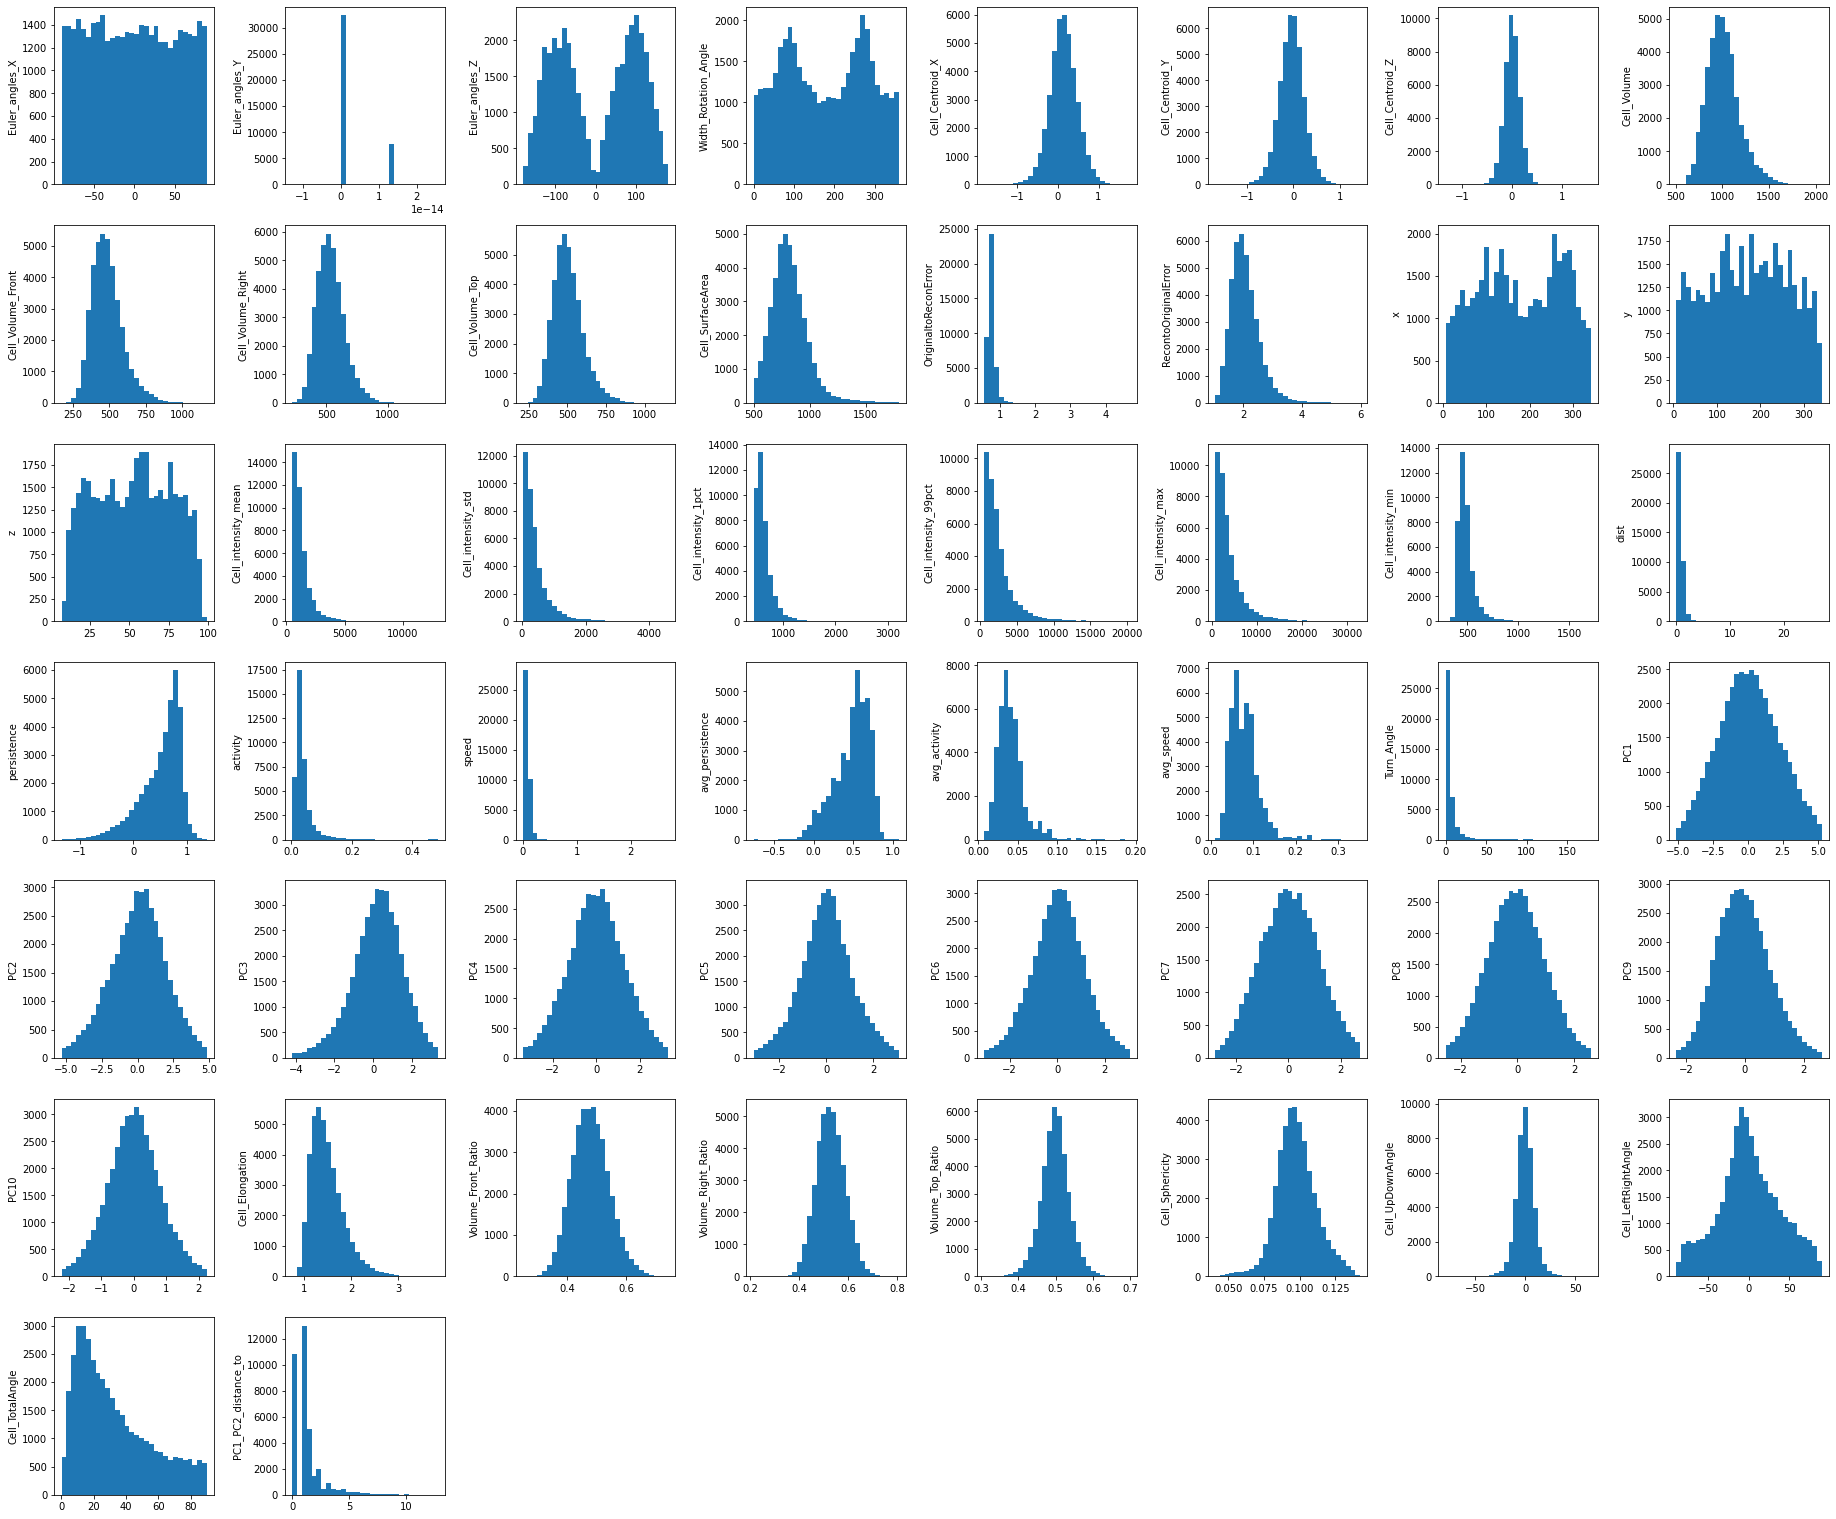

In [7]:
################# LOOK AT STAT DISTRIBUTIONS ######################


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame.drop(columns = to_remove)
smallerframe = smallerframe.drop(columns = ['cell','cell.1','CellID','structure','frame','Treatment'])
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    ax.hist(smallerframe.iloc[:,i], 30)#, color=colors[i]) , 30, (-2,2))
    ax.set_ylabel(smallerframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1

        
#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()
# plt.savefig(folder_fl + 'Shape Metric Histograms.png', bbox_inches='tight')

In [38]:
TotalFrame.Turn_Angle.dropna().sort_values(ascending=False).head(200)

55578    179.369632
29967    178.818021
29953    178.317207
43995    177.448597
38274    176.540657
            ...    
29965     84.122093
58635     84.107094
38362     84.095905
42329     83.551875
38357     83.318013
Name: Turn_Angle, Length: 200, dtype: float64

In [8]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Treatment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z','Temperature'])
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
        f_val, p_val = ss.f_oneway(*samples)
        print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
        if p_val < 0.05:
            siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c].dropna(), ModeFrame.loc[ModeFrame[c].dropna().index.to_list()].Treatment))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Name: Cell_Volume, F value: 13.951714105297494, p value: 8.812786157959965e-07
Name: Cell_Volume_Front, F value: 55.60624116819457, p value: 8.281101759871179e-25
Name: Cell_Volume_Right, F value: 15.934488193729303, p value: 1.21703551015463e-07
Name: Cell_Volume_Top, F value: 5.307795936491019, p value: 0.0049598811039272385
Name: Cell_SurfaceArea, F value: 169.7654554375993, p value: 7.885735674700429e-74
Name: dist, F value: 19.608672490479957, p value: 3.108026362015214e-09
Name: persistence, F value: 10.09050241042953, p value: 4.169358186131824e-05
Name: speed, F value: 15.31727225602434, p value: 2.2543875996807397e-07
Name: avg_persistence, F value: 23.493710098076132, p value: 6.440201251172848e-11
Name: avg_speed, F value: 43.086019417744424, p value: 2.1309944389125392e-19
Name: Instant_Signal_Velocity, F value: 31.4386033704416, p value: 2.335710780004183e-14
Name: Signal_Velocity, F value: 211.43011224463186, p value: 1.4500688796751396e-91
Name: Total_Distance_Travelled,

Name Instant_Signal_Velocity           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
    Galvanotaxis Pre-Galvanotaxis  -0.0056  0.101 -0.0119  0.0008  False
    Galvanotaxis           Random  -0.0111    0.0 -0.0144 -0.0078   True
Pre-Galvanotaxis           Random  -0.0055 0.1004 -0.0119  0.0008  False
------------------------------------------------------------------------
Name PC1           Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1           group2      meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------
    Galvanotaxis Pre-Galvanotaxis   0.0801 0.3334 -0.0526 0.2129  False
    Galvanotaxis           Random   0.2334    0.0  0.1651 0.3016   True
Pre-Galvanotaxis           Random   0.1533 0.0177  0.0214 0.2851   True
-------------------

Name dist           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
    Galvanotaxis Pre-Galvanotaxis   0.0095 0.9219 -0.0483  0.0673  False
    Galvanotaxis           Random  -0.0749    0.0 -0.1046 -0.0452   True
Pre-Galvanotaxis           Random  -0.0844 0.0016 -0.1418  -0.027   True
------------------------------------------------------------------------
Name persistence           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
    Galvanotaxis Pre-Galvanotaxis  -0.0266 0.0129 -0.0486 -0.0046   True
    Galvanotaxis           Random  -0.0199 0.0001 -0.0313 -0.0086   True
Pre-Galvanotaxis           Random   0.0067 0.7557 -0.0152  0.0285  False
------------------------

In [15]:
#get the number of images of cells and unique cells per migration mode
samplesize = pd.DataFrame([])

for m, mod in TotalFrame.groupby('Treatment'):
    imnum = len(mod)
    cellnum = len(mod.CellID.unique())
    samplesize = samplesize.append(pd.DataFrame({'Treatment':m,
                                                 'Cells':cellnum, 
                                                'Images':imnum}, index = [0]))

samplesize = samplesize.reset_index(drop=True)
samplesize

,Migration_Mode,Cells,Images
0,Random,242,11538
1,Pre-Galvanotaxis,108,1658
2,Galvanotaxis,236,10744


In [4]:
########################## EXPERIMENT DIFFERENCES SANITY CHECK ####################

############### get list of metrics that are significant using anova ############
ModeFrame = TotalFrame.copy()
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import scipy.stats as ss
confoundlist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Treatment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z','Temperature'])
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c not in ['Treatment','Date','Experiment','Experiment_Number']:
        # Performing two-way ANOVA 
        model = ols(f'{c} ~ C(Date) + C(Experiment_Number) + C(Date):C(Experiment_Number)', 
                    data=ModeFrame).fit() 
        result = sm.stats.anova_lm(model, type=2) 


        if any(result['PR(>F)'].values <0.05):
            # Print the result 
            print(c, result) 
            confoundlist.append(c) 
# siglist = sorted(siglist)
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# for c in siglist:
#     print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c].dropna(), ModeFrame.loc[ModeFrame[c].dropna().index.to_list()].Treatment))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Cell_Volume                                    df        sum_sq       mean_sq           F  \
C(Date)                           1.0  1.551074e+07  1.551074e+07  637.528453   
C(Experiment_Number)              2.0  8.369725e+06  4.184863e+06  172.007843   
C(Date):C(Experiment_Number)      2.0  1.487690e+06  7.438450e+05   30.573804   
Residual                      19797.0  4.816509e+08  2.432949e+04         NaN   

                                     PR(>F)  
C(Date)                       1.781096e-138  
C(Experiment_Number)           8.701125e-75  
C(Date):C(Experiment_Number)   5.526237e-14  
Residual                                NaN  
Cell_Volume_Front                                    df        sum_sq       mean_sq           F  \
C(Date)                           1.0  8.179870e+06  8.179870e+06  820.439098   
C(Experiment_Number)              2.0  4.579752e+06  2.289876e+06  229.674042   
C(Date):C(Experiment_Number)      2.0  6.479934e+05  3.239967e+05   32.496793   
Residual  

Euclidean_Distance_Travelled                                    df        sum_sq        mean_sq  \
C(Date)                           1.0  4.745719e+05  474571.890763   
C(Experiment_Number)              2.0  6.304637e+05  315231.867995   
C(Date):C(Experiment_Number)      2.0  3.377509e+03    1688.754582   
Residual                      19440.0  1.681301e+07     864.866764   

                                       F         PR(>F)  
C(Date)                       548.722544  1.082882e-119  
C(Experiment_Number)          364.486047  3.994444e-156  
C(Date):C(Experiment_Number)    1.952618   1.419299e-01  
Residual                             NaN            NaN  
Turn_Angle                                    df        sum_sq      mean_sq          F  \
C(Date)                           1.0  6.065062e+03  6065.062301  37.933796   
C(Experiment_Number)              2.0  5.734780e+02   286.739024   1.793403   
C(Date):C(Experiment_Number)      2.0  1.264153e+03   632.076619   3.953309   
Res

Cell_Sphericity                                    df    sum_sq   mean_sq           F  \
C(Date)                           1.0  0.109440  0.109440  763.689523   
C(Experiment_Number)              2.0  0.103602  0.051801  361.476105   
C(Date):C(Experiment_Number)      2.0  0.084137  0.042069  293.560993   
Residual                      19797.0  2.836997  0.000143         NaN   

                                     PR(>F)  
C(Date)                       5.671467e-165  
C(Experiment_Number)          6.478026e-155  
C(Date):C(Experiment_Number)  2.301633e-126  
Residual                                NaN  
Cell_UpDownAngle                                    df        sum_sq     mean_sq         F  \
C(Date)                           1.0  9.223522e+02  922.352170  9.866647   
C(Experiment_Number)              2.0  3.728653e+02  186.432653  1.994320   
C(Date):C(Experiment_Number)      2.0  1.104079e+02   55.203954  0.590531   
Residual                      19797.0  1.850660e+06   93.481827

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


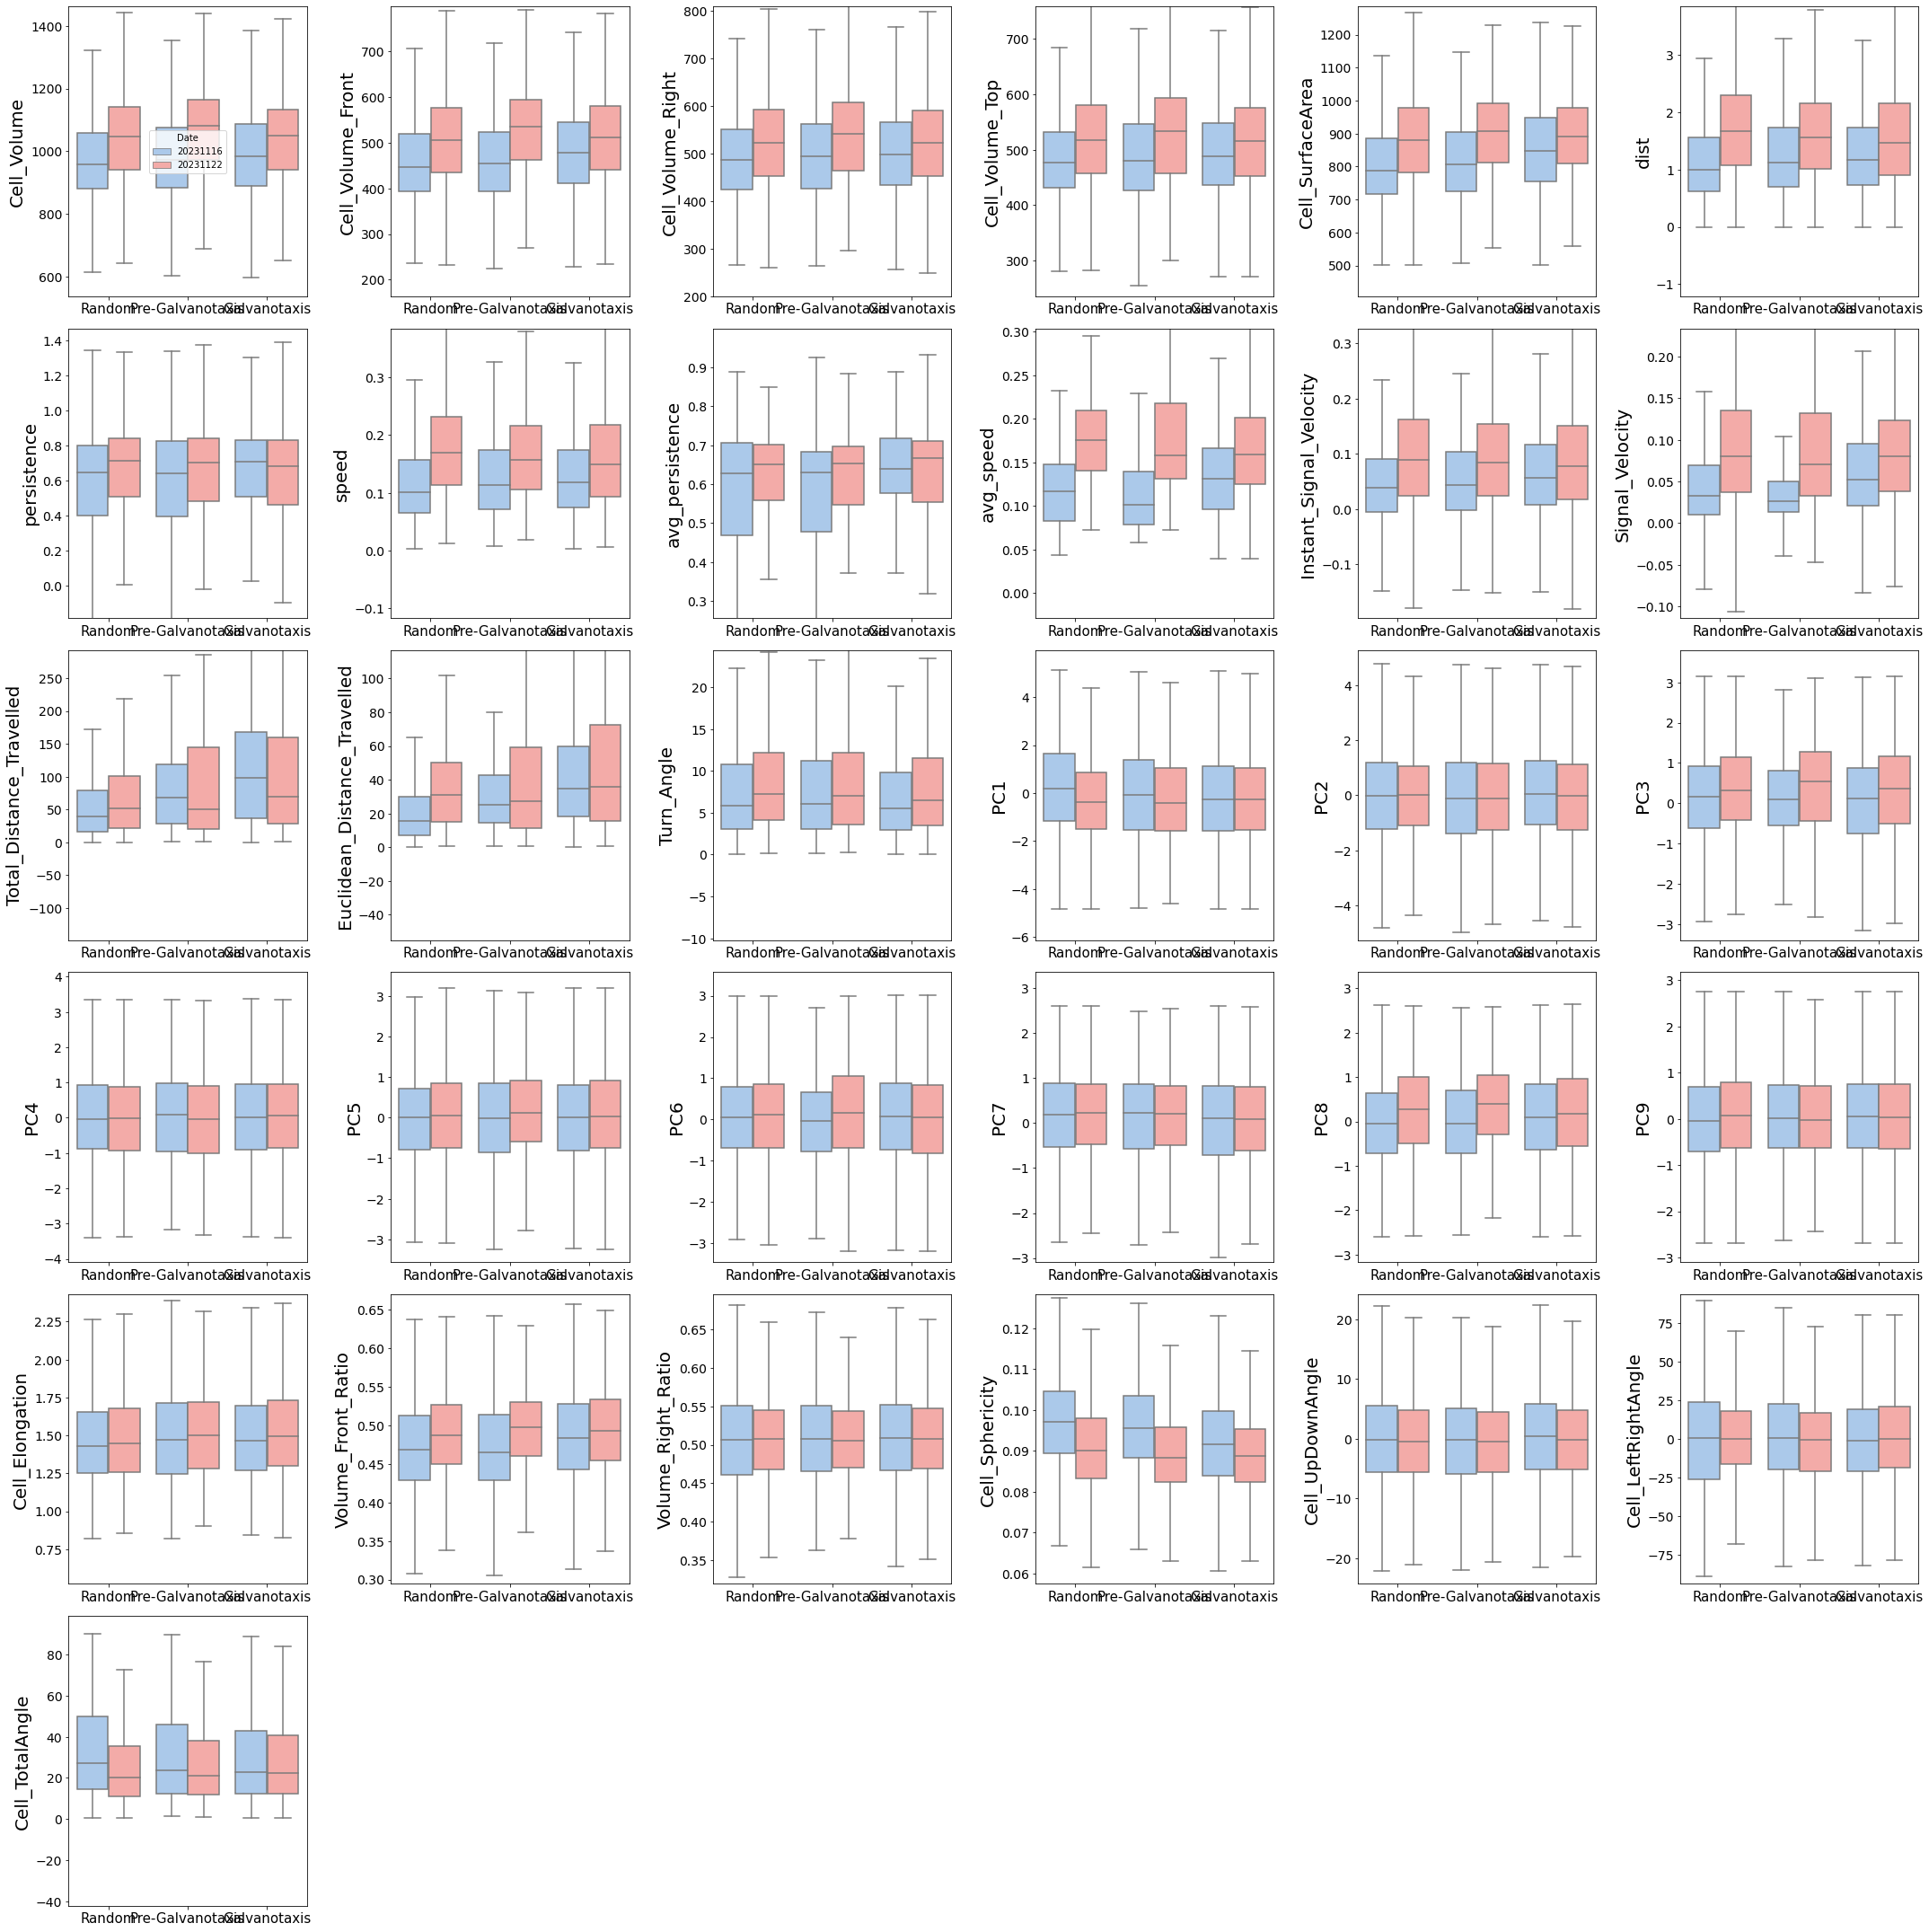

In [5]:
########################## EXPERIMENT DIFFERENCES SANITY CHECK GRAPH BY DATE ####################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation', 'Cell_Sphericity',
              'Volume_Front_Ratio','speed','persistence',
             'Turn_Angle','Angular_Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell Elongation (a.u.)', 'Cell Sphericity (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)', 'Angular Bias (°)']

sp = math.ceil(math.sqrt(len(confoundlist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*5,sp*5))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(confoundlist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.boxplot(data=TotalFrame, x='Treatment', y=sig, hue = 'Date',palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = TotalFrame[sig].quantile(0.25)
    Q3 = TotalFrame[sig].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel(sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
# plt.savefig(savedir + 'Temperature comparison significant metric boxes.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


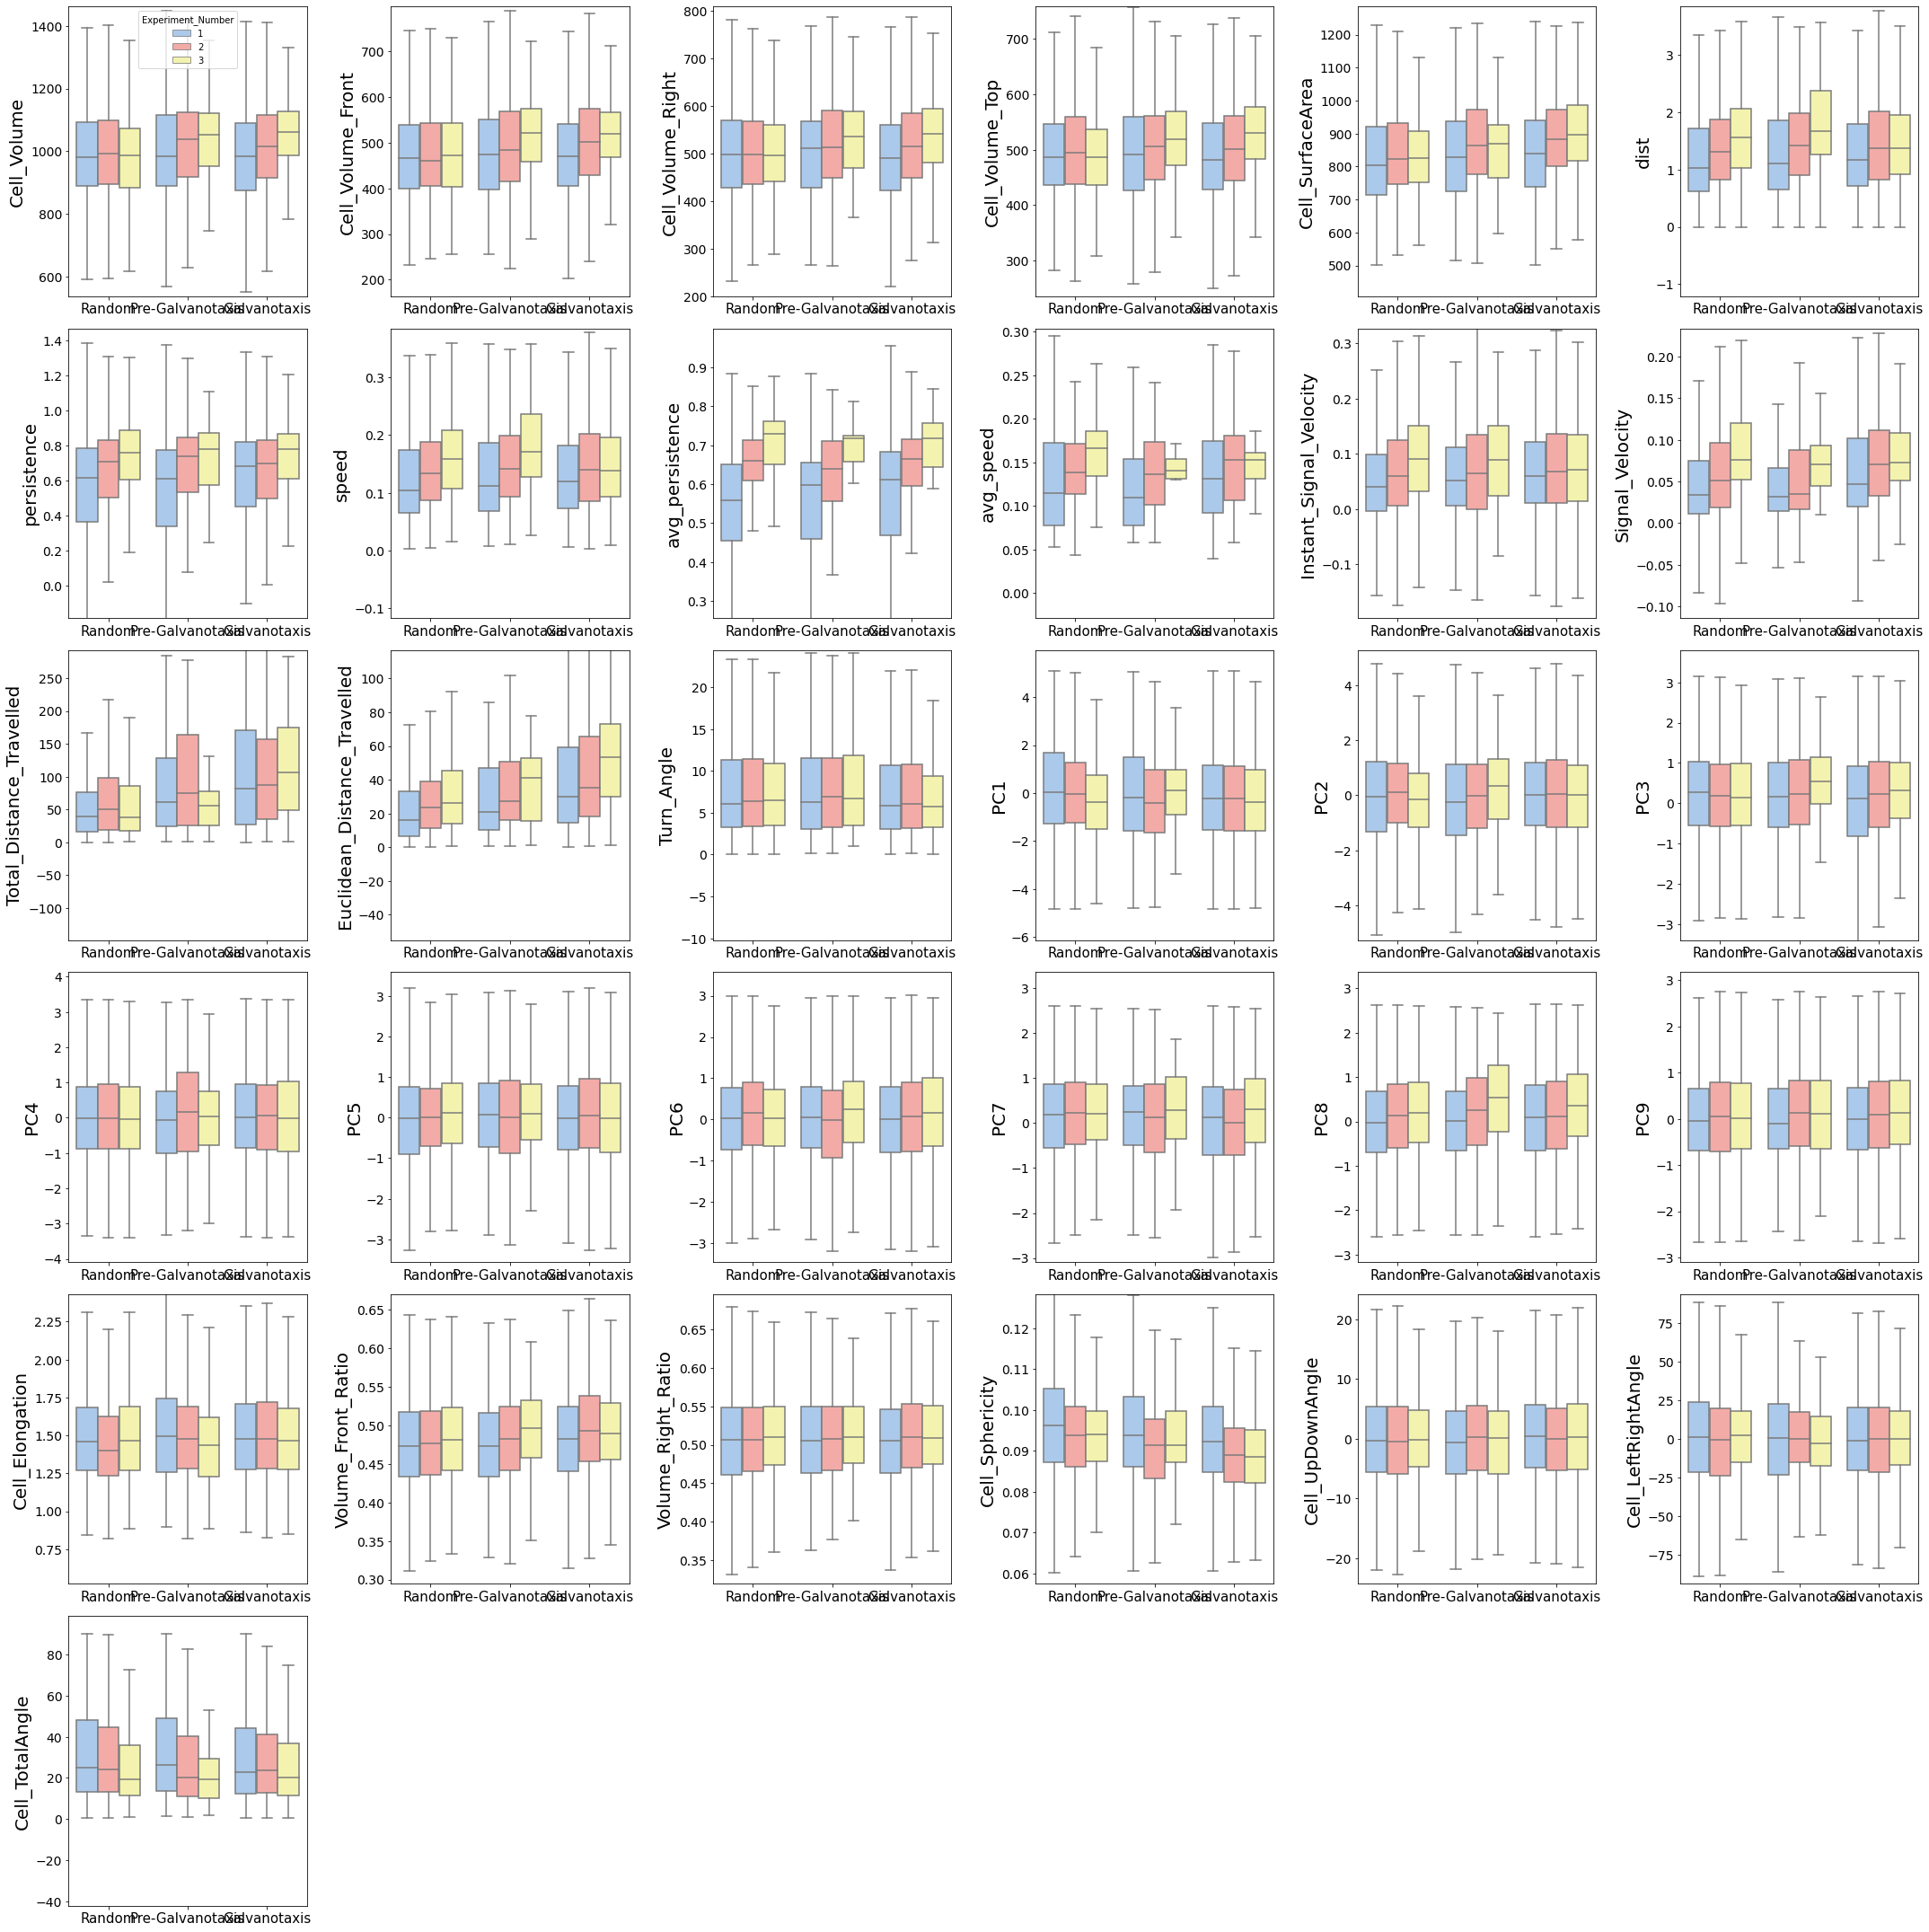

In [6]:
########################## EXPERIMENT DIFFERENCES SANITY CHECK GRAPH BY DATE ####################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation', 'Cell_Sphericity',
              'Volume_Front_Ratio','speed','persistence',
             'Turn_Angle','Angular_Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell Elongation (a.u.)', 'Cell Sphericity (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)', 'Angular Bias (°)']

sp = math.ceil(math.sqrt(len(confoundlist)))
fig, axes = plt.subplots(sp, sp, figsize=(sp*5,sp*5))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(confoundlist):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    
    bp = sns.boxplot(data=TotalFrame, x='Treatment', y=sig, hue = 'Experiment_Number' ,palette = colorlist,# width = 0.15, 
            fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    Q1 = TotalFrame[sig].quantile(0.25)
    Q3 = TotalFrame[sig].quantile(0.75)  
    IQR = Q3 - Q1
    axli[i].set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
    axli[i].set_ylabel(sig, fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)
    if i>0:
        axli[i].legend_ = None
for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
# plt.savefig(savedir + 'Temperature comparison significant metric boxes.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


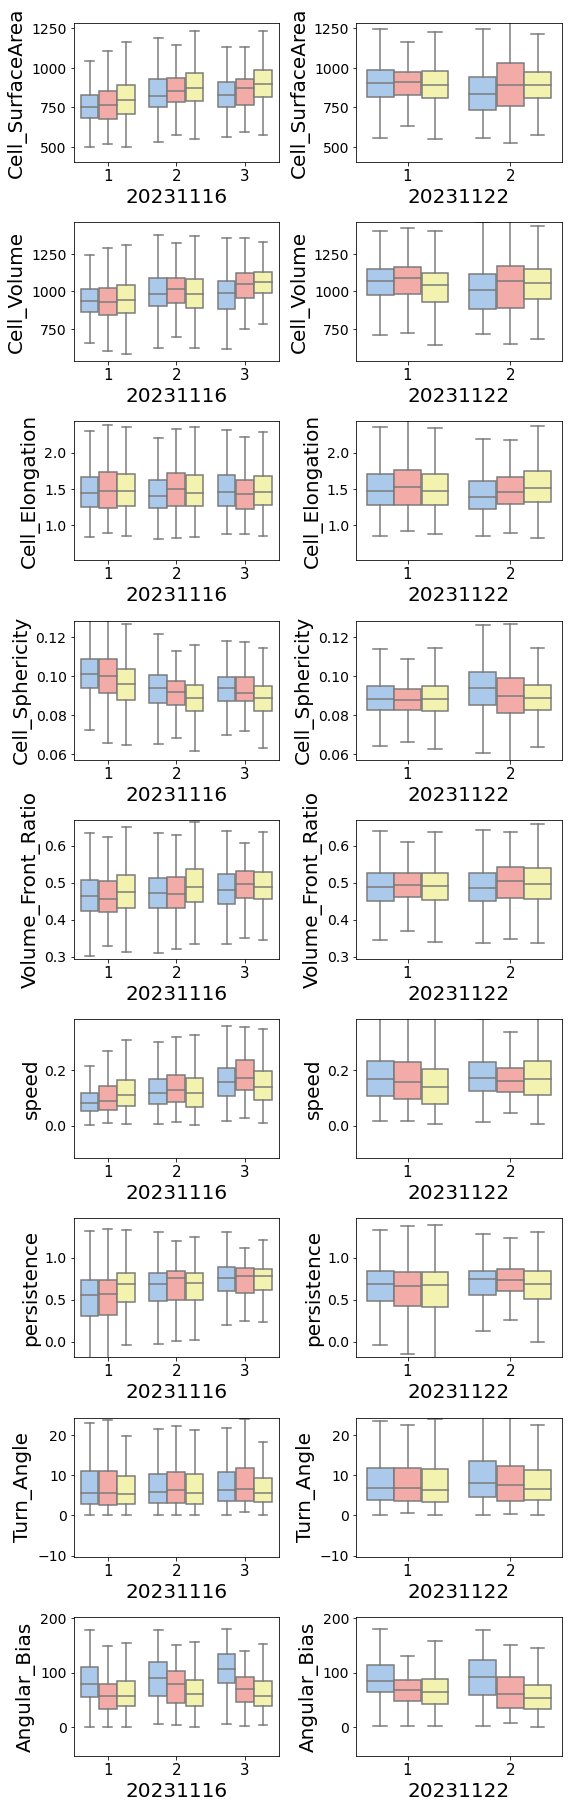

In [7]:
########################## EXPERIMENT DIFFERENCES SANITY CHECK GRAPH BY DATE AND EXPERIMENT NUMBER ####################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular_Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation', 'Cell_Sphericity',
              'Volume_Front_Ratio','speed','persistence',
             'Turn_Angle','Angular_Bias']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell Elongation (a.u.)', 'Cell Sphericity (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle (°)', 'Angular Bias (°)']


fig, axes = plt.subplots(len(smallersig), len(TotalFrame.Date.unique()), figsize=(8,25))#, sharex=True)

# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(smallersig):
#     vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, hue = 'Temperature', palette = colorlist, inner = None, ax=axli[i], )
    for d, dd in enumerate(TotalFrame.Date.unique()):
        ax = axes[i,d]
        bp = sns.boxplot(data=TotalFrame[TotalFrame.Date ==dd], x='Experiment_Number', y=sig, hue = 'Treatment' ,palette = colorlist,# width = 0.15, 
                fliersize=0, boxprops={'zorder': 2}, ax=ax)
        Q1 = TotalFrame[sig].quantile(0.25)
        Q3 = TotalFrame[sig].quantile(0.75)  
        IQR = Q3 - Q1
        ax.set_ylim(Q1 - 1.75*IQR, Q3 + 1.75*IQR)
        ax.set_ylabel(sig, fontsize=20)
        ax.set_xlabel(dd, fontsize=20)
        ax.tick_params('y', labelsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
#         if i>0:
        ax.legend_ = None


    
plt.tight_layout()
# plt.savefig(savedir + 'Temperature comparison significant metric boxes.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


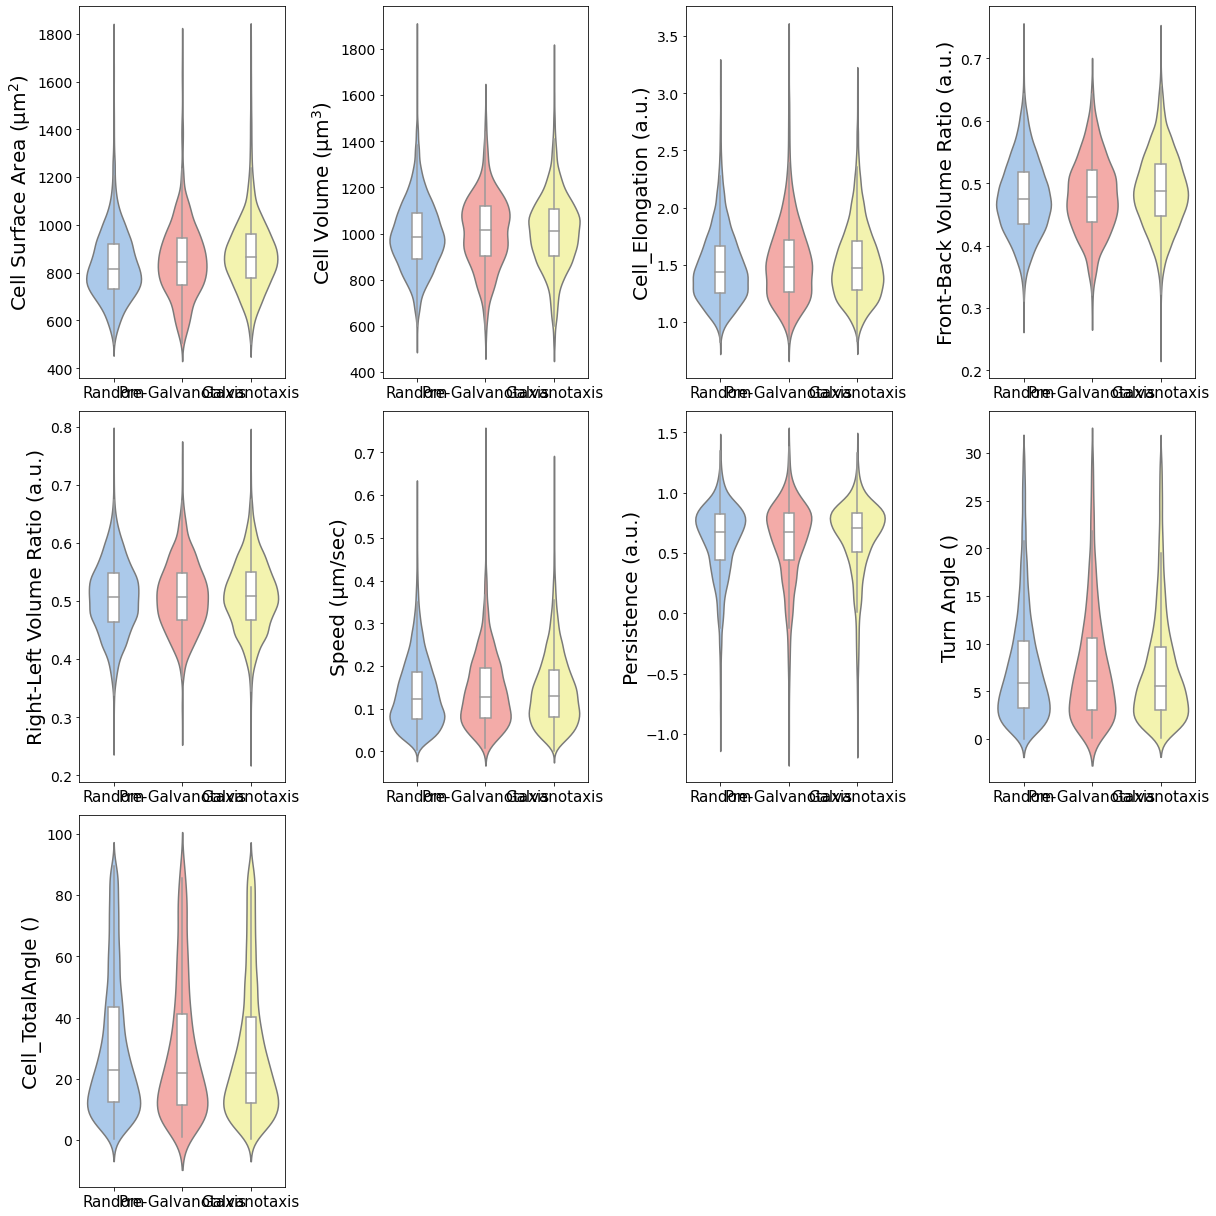

In [15]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular Bias'] = angles

#### remove speed outliers
# tempframe = TotalFrame[TotalFrame.speed<0.8]
tempframe = TotalFrame[TotalFrame.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation',
              'Volume_Front_Ratio','Volume_Right_Ratio','speed','persistence',
             'Turn_Angle', 'Cell_TotalAngle']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell_Elongation (a.u.)',
             'Front-Back Volume Ratio (a.u.)','Right-Left Volume Ratio (a.u.)','Speed (µm/sec)','Persistence (a.u.)',
            'Turn Angle ()', 'Cell_TotalAngle ()']


fig, axes = plt.subplots(3, 4, figsize=(17,17))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(smallersig):
    vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, palette = colorlist, inner = None, ax=axli[i], )
    bp = sns.boxplot(data=tempframe, x='Treatment', y=sig, width = 0.15, 
            color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(axli[i].get_xticklabels(), fontsize = 15)

for a in range(i+1, len(axli)):
    axli[a].remove()

    
plt.tight_layout()
plt.savefig(savedir + 'Treatment significant metric violins.png', bbox_inches='tight')




# fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
# tb = ax.table(cellText=samplesize.values[:,1:],
#       rowLabels=samplesize.values[:,0],
#       rowColours=colorlist,
#       colLabels=samplesize.columns[1:].to_list(),
#         loc= 'center right',
#         cellLoc = 'center',
#         colWidths = [0.35]*len(samplesize))
# tb.scale(0.8,3)
# tb.auto_set_font_size(False)
# tb.set_fontsize(18)
# ax.axis('off')
# plt.savefig(savedir + 'Treatment significant metric table.png', bbox_inches='tight')




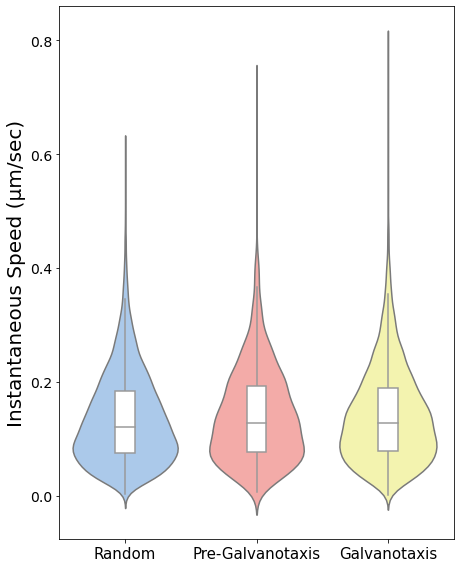

In [4]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,-1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular Bias'] = angles

#### remove speed outliers
tempframe = TotalFrame[TotalFrame.speed<0.8]
tempframe = tempframe[tempframe.Turn_Angle<30]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['speed']
siglabels = ['Instantaneous Speed (µm/sec)']


fig, ax = plt.subplots(1, 1, figsize=(6.5,8))#, sharex=True)

vp = sns.violinplot(data=tempframe, x='Treatment', y='speed', palette = colorlist, inner = None, ax=ax, )
bp = sns.boxplot(data=tempframe, x='Treatment', y='speed', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, ax=ax)
ax.set_ylabel(siglabels[0], fontsize=20)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels(tempframe.Treatment.unique(), fontsize = 15)#, rotation=45)#, ha = 'right')


plt.tight_layout()
plt.savefig(savedir + 'speed metric violins.png', bbox_inches='tight')




C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


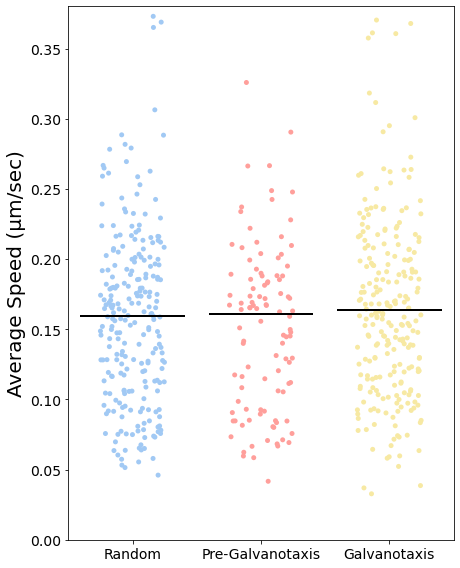

In [13]:
tempframe = TotalFrame[TotalFrame.speed<0.8]
realavg = []
for i, c in tempframe.groupby(['CellID', 'Treatment']):
    realavg.append([i[0], i[1], c.speed.mean()])
newrealavg = pd.DataFrame(realavg, columns = ['CellID','Treatment','Average Speed (µm/sec)'])


colorlist = ['#a1c9f4', '#ff9f9b', '#f7e9a3']

fig, ax = plt.subplots(figsize = (6.5,8))
sns.stripplot(newrealavg['Treatment'],newrealavg['Average Speed (µm/sec)'], jitter = 0.25, palette = colorlist, ax = ax)

sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=newrealavg['Treatment'],
            y=newrealavg['Average Speed (µm/sec)'],
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)

ax.set_xlabel('')
ax.set_ylabel(ax.get_ylabel(),fontsize=20)
ax.set_ylim(0,0.38)
ax.tick_params('x', labelsize=14)
ax.tick_params('y', labelsize=14)


plt.tight_layout()
plt.savefig(savedir + 'average speed metric jitter.png', bbox_inches='tight')

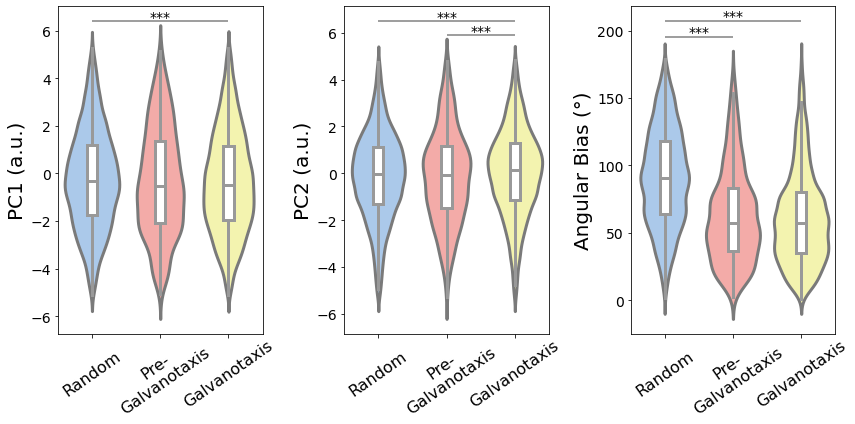

In [46]:
############### Metric distributions by treatment FOR ASCB #################################

import re


#### remove speed outliers
tempframe = TotalFrame[TotalFrame.speed<0.8]
# tempframe = tempframe[tempframe.Turn_Angle<30]
# tempframe = tempframe[tempframe.PC1_PC2_distance_to<3]


colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['PC1','PC2','Angular Bias']
siglabels = ['PC1 (a.u.)','PC2 (a.u.)','Angular Bias (°)']



fig, axes = plt.subplots(1, len(smallersig), figsize=(12,6))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Treatment'):
for i, sig in enumerate(smallersig):
    vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, palette = colorlist, linewidth=3, inner = None, ax=axli[i], )
    bp = sns.boxplot(data=tempframe, x='Treatment', y=sig, width = 0.15, 
            color = 'white', showcaps=False, linewidth=3, fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(['Random','Pre-\nGalvanotaxis','Galvanotaxis'], fontdict= {'fontsize': 16,
                                                                                      'verticalalignment':'center',
                                                                                      'rotation':35,
                                                                                      'y':-.1})

# ax.tick_params('x', labelsize=16, rotation = 35)

axli[0].hlines(6.4, 0, 2, colors='grey', linestyles='solid')
axli[0].text(1,6.41,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

    
axli[1].hlines(5.9, 1, 2, colors='grey', linestyles='solid')
axli[1].text(1.5,5.91,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[1].hlines(6.5, 0, 2, colors='grey', linestyles='solid')
axli[1].text(1,6.51,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
    
    

axli[2].hlines(195, 0, 1, colors='grey', linestyles='solid')
axli[2].text(0.5,196,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})
axli[2].hlines(207, 0, 2, colors='grey', linestyles='solid')
axli[2].text(1,208,'***',fontdict= {'fontsize': 14,
                               'horizontalalignment':'center'})

    
    
plt.tight_layout()
plt.savefig(savedir + f'treatment metric violins FOR ASCB 2023.png', bbox_inches='tight')



In [23]:
for i, x in TotalFrame.groupby('Treatment'):
    print(i,x.PC1_PC2_distance_to.mean())

Random 1.4889567493594047
Pre-Galvanotaxis 1.3944488708735976
Galvanotaxis 1.376317035792713


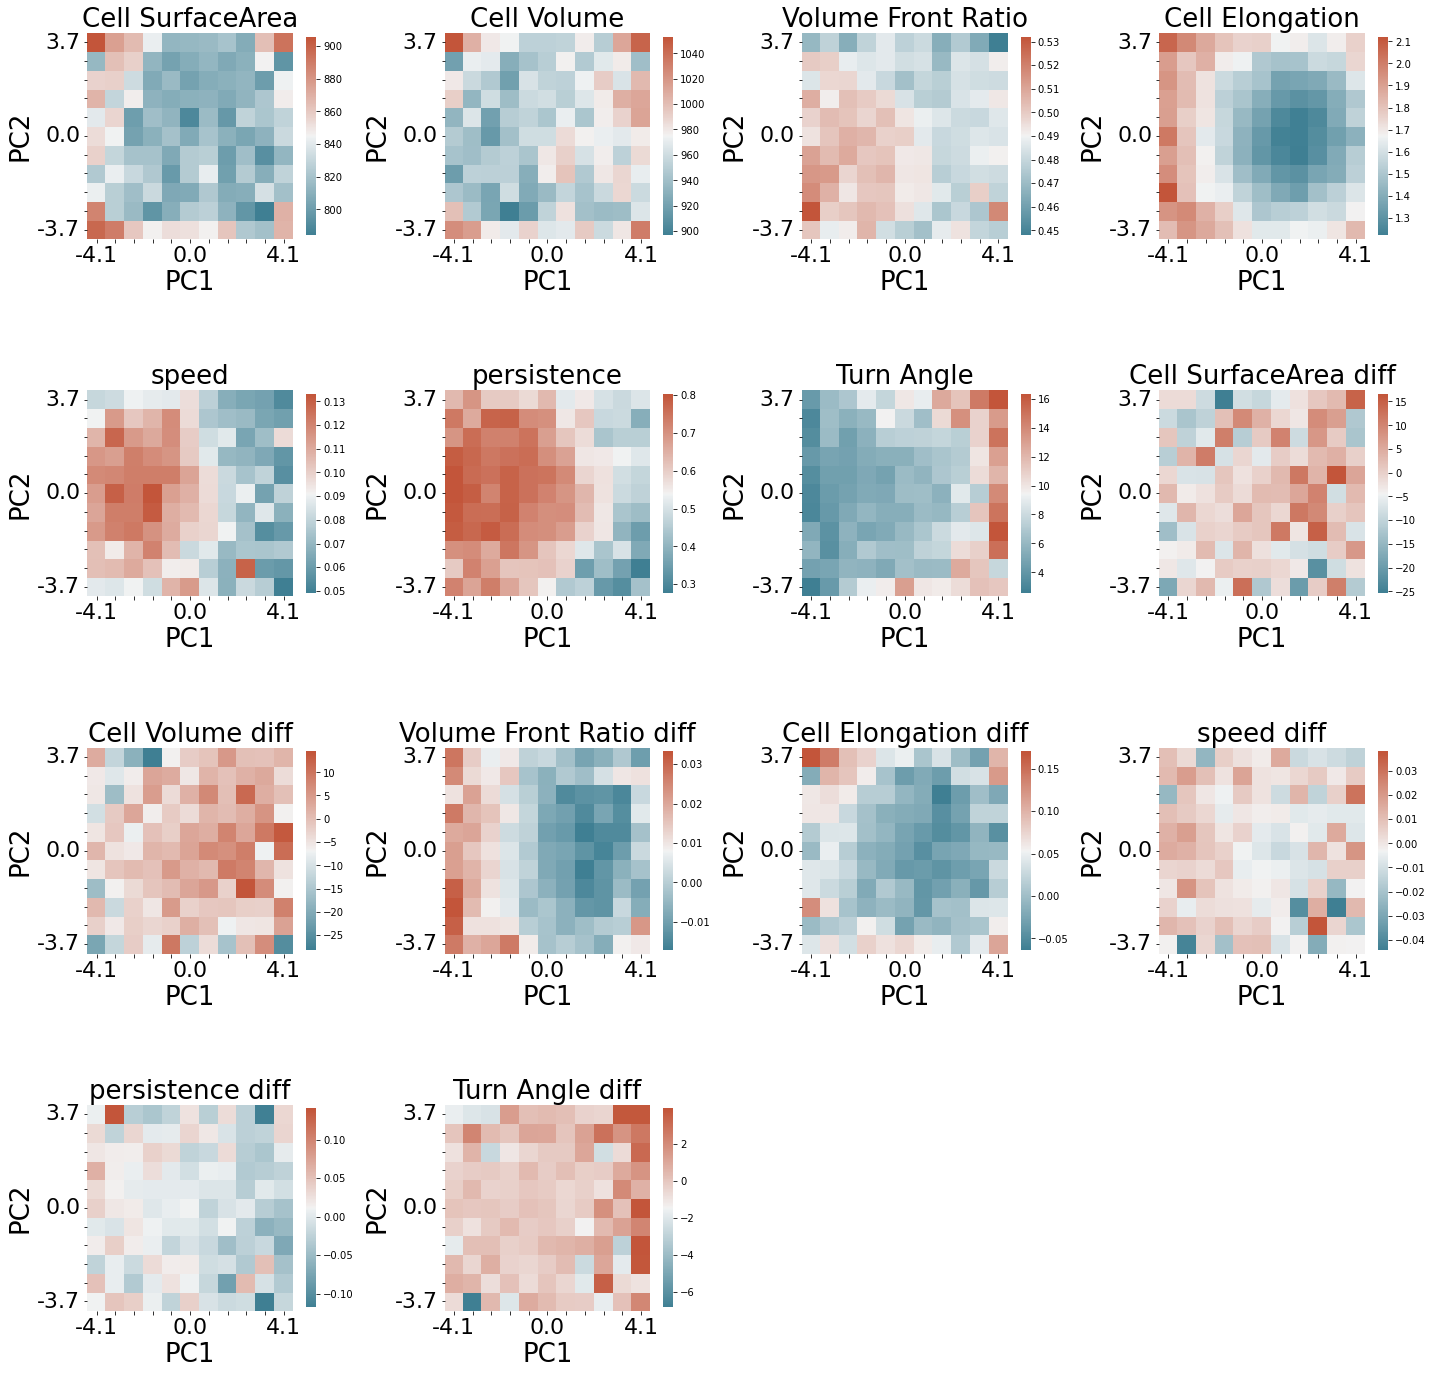

In [11]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 22
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC2.to_list()],
            rotation=0,
            fontsize = 22
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i].replace('_',' '), fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

In [ ]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRIC DIFFERENTIALS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(metrics):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[metrics[i]]
                else:
                    bighm[y,x] = current[metrics[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(metrics[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

NameError: name 'cbar_ax' is not defined

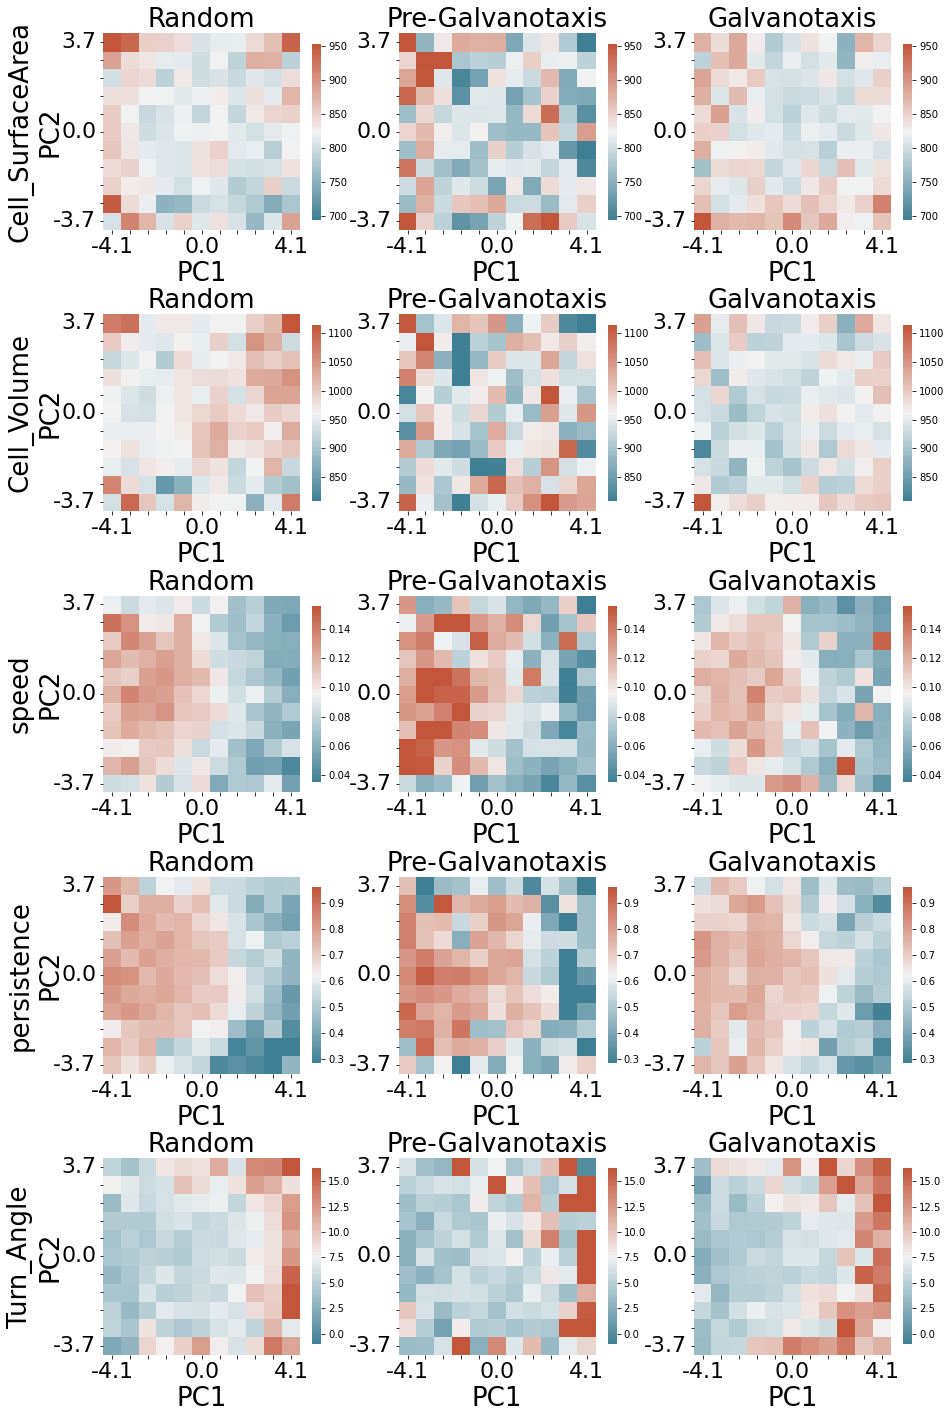

In [10]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(len(metrics),len(TotalFrame.Treatment.unique()),figsize=(15,len(metrics)*5))


for i, met in enumerate(metrics):
    for a, ax in enumerate(axes[i]):
        mm = TotalFrame.Treatment.unique()[a]
        mdf = TotalFrame[TotalFrame.Treatment==mm]
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((len(axes[i]),nbins,nbins))
        for n in range(bighm.shape[0]):
            mdf = TotalFrame[TotalFrame.Treatment==TotalFrame.Treatment.unique()[n]]
            for x in range(nbins):
                for y in range(nbins):
                    current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC2bins'] == y+1)].dropna(subset=[met])
                    if current.empty:
                        bighm[n,y,x] = 0
                    elif len(current)==1:
                        bighm[n,y,x] = current[met]
                    else:
                        bighm[n,y,x] = current[met].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm[a,:,:],
            vmin=np.mean(bighm[np.nonzero(bighm)])-(bighm.std()*2),
            vmax=np.mean(bighm)+(bighm.std()*2), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.75}
        )
        ax.set_xticklabels(
            [round(x,1) for x in centers.PC1.to_list()],
            fontsize = 22
        )
        ax.set_yticklabels(
            [round(x,1) for x in centers.PC2.to_list()],
            rotation=0,
            fontsize = 22
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)      
        if (a == 0):
            ax.set_ylabel(f'{met}\nPC2', fontsize = 26, labelpad=-10)
#         else:
#             ax.set_ylabel(f'PC2', fontsize = 26, labelpad=-10)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps separated.png', bbox_inches='tight')

C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


Name Cell_Centroid_X          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj  lower    upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  13.8299   0.0  12.5991 15.0607   True
Chem_Directed_Chem Random_Chem   2.3165   0.0   1.1808  3.4522   True
Chem_Directed_Chem Random_Galv   6.5544   0.0   5.2757  7.8331   True
         Galv_Galv Random_Chem -11.5134   0.0 -12.6137 -10.413   True
         Galv_Galv Random_Galv  -7.2755   0.0  -8.5229 -6.0281   True
       Random_Chem Random_Galv   4.2379   0.0   3.0842  5.3916   True
---------------------------------------------------------------------
Name Cell_Centroid_Y          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   4.8776    0.0  

Name Cell_intensity_99pct          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  -6.9099    0.0 -10.4941 -3.3257   True
Chem_Directed_Chem Random_Chem   9.9033    0.0    6.596 13.2106   True
Chem_Directed_Chem Random_Galv  -2.6488 0.2602  -6.3725  1.0749  False
         Galv_Galv Random_Chem  16.8132    0.0  13.6089 20.0175   True
         Galv_Galv Random_Galv   4.2611 0.0138   0.6286  7.8937   True
       Random_Chem Random_Galv -12.5521    0.0 -15.9117 -9.1924   True
----------------------------------------------------------------------
Name Cell_intensity_max          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_G

Name PC8          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   1.4552    0.0  1.2838  1.6265   True
Chem_Directed_Chem Random_Chem   0.3745    0.0  0.2164  0.5326   True
Chem_Directed_Chem Random_Galv   1.2123    0.0  1.0343  1.3903   True
         Galv_Galv Random_Chem  -1.0807    0.0 -1.2339 -0.9275   True
         Galv_Galv Random_Galv  -0.2429 0.0019 -0.4165 -0.0692   True
       Random_Chem Random_Galv   0.8378    0.0  0.6772  0.9984   True
---------------------------------------------------------------------
Name PC9          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   0.1491 0.0833 -0.0127  0.3108  False
Ch

Name nucleus_Structure_intensity_1pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Chem      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Galv      nan   nan   nan   nan  False
         Galv_Galv Random_Chem      nan   nan   nan   nan  False
         Galv_Galv Random_Galv      nan   nan   nan   nan  False
       Random_Chem Random_Galv      nan   nan   nan   nan  False
----------------------------------------------------------------
Name nucleus_Structure_intensity_99pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed

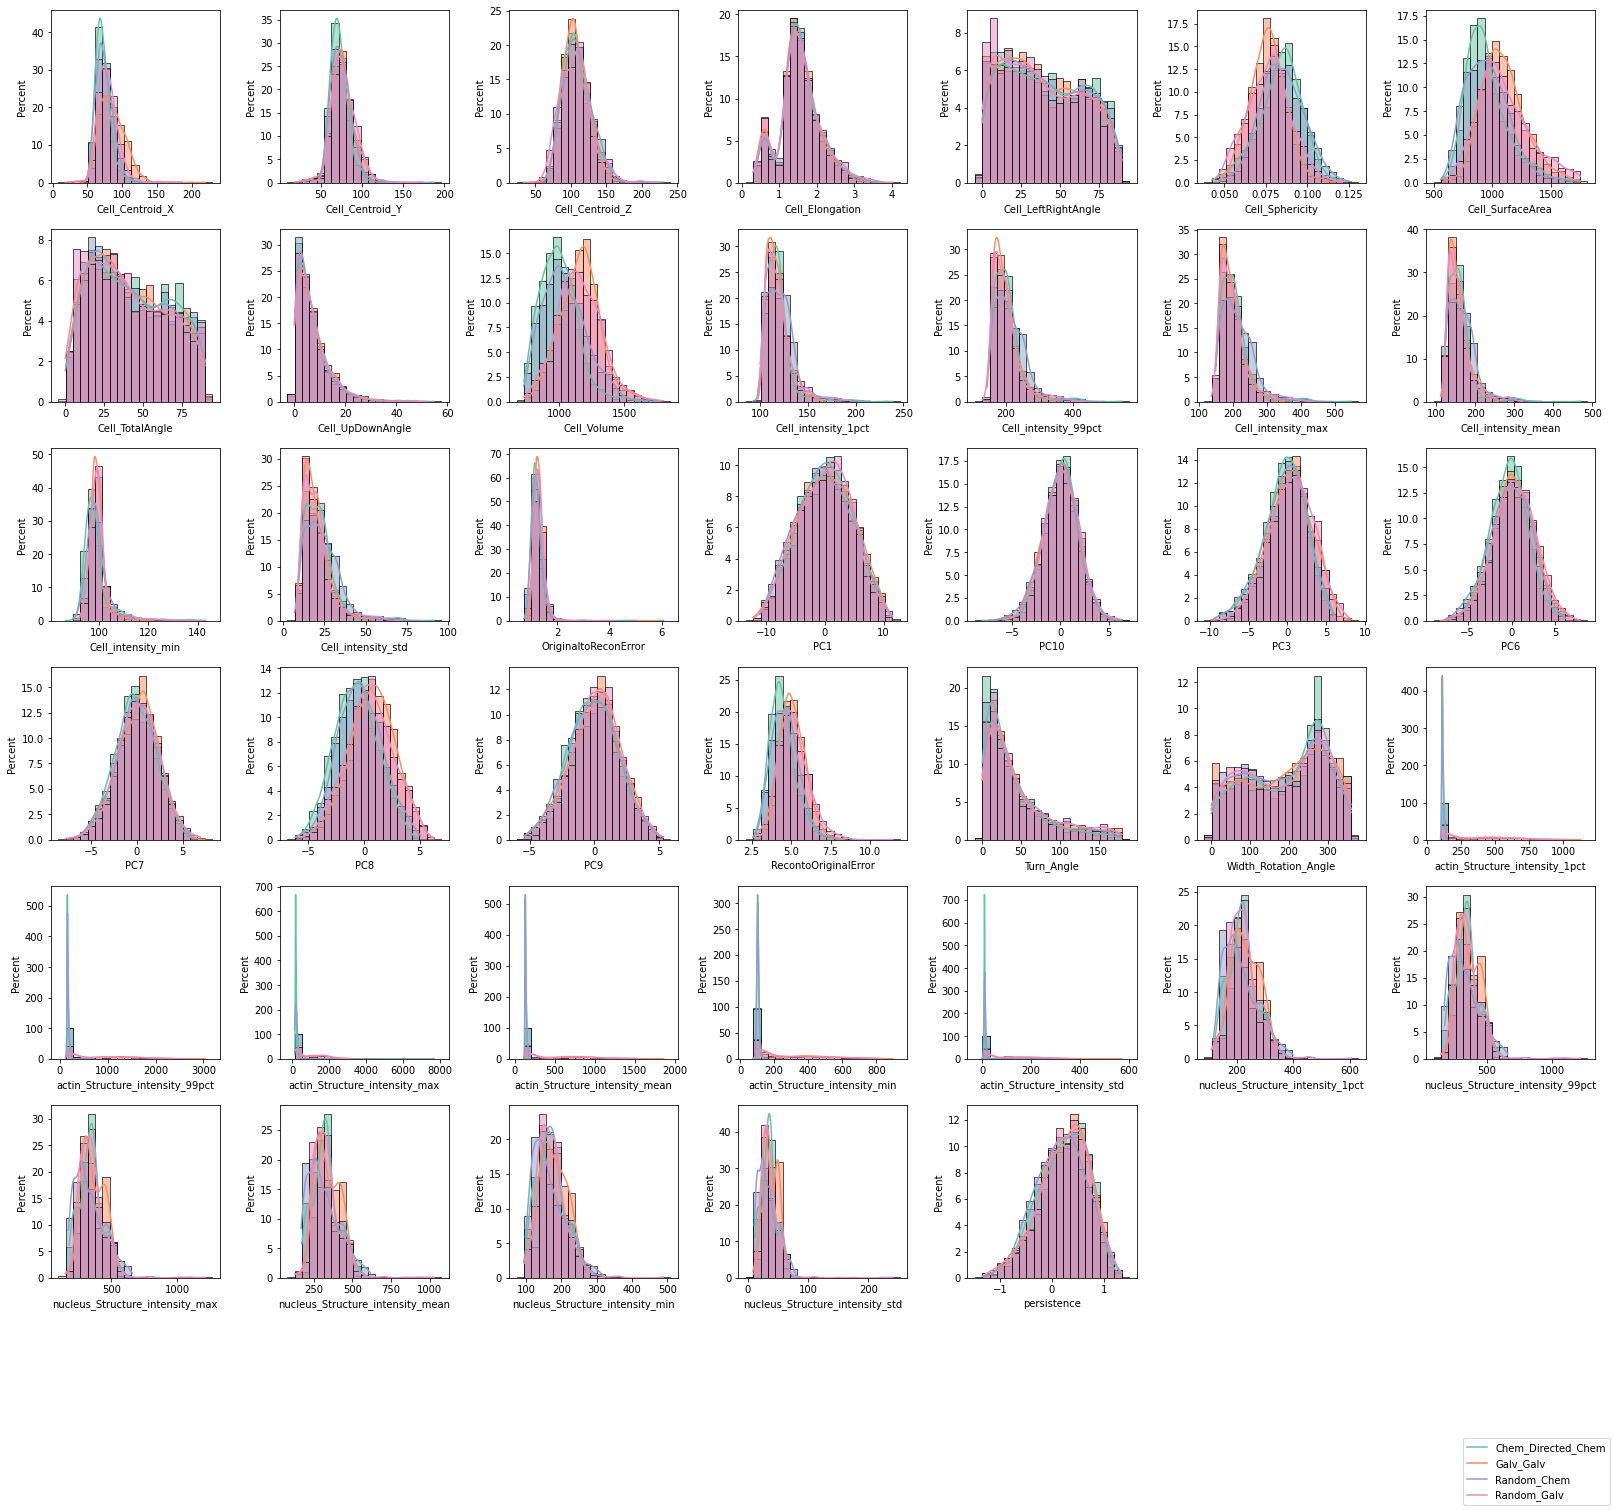

In [68]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Treatment' in x])

for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Treatment','Experiment'])[c]]
    f_val, p_val = ss.f_oneway(*samples)
#     print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c], 
                                         [one+'_'+two for one, two in zip(ModeFrame['Treatment'].to_list(), ModeFrame['Experiment'].to_list())]))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']


################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())

CoRo = math.ceil(math.sqrt(len(siglist)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(siglist):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Treatment','Experiment'])[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
    sns.histplot(ax = ax, data=samples[2], bins=binss, stat='percent', color = colors[2], kde = True)
    sns.histplot(ax = ax, data=samples[3], bins=binss, stat='percent', color = colors[3], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(['_'.join(g) for g, i in ModeFrame.groupby(['Treatment','Experiment'])], loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Treatment.unique(), loc ='lower right')
plt.tight_layout()
# plt.savefig(folder_fl + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


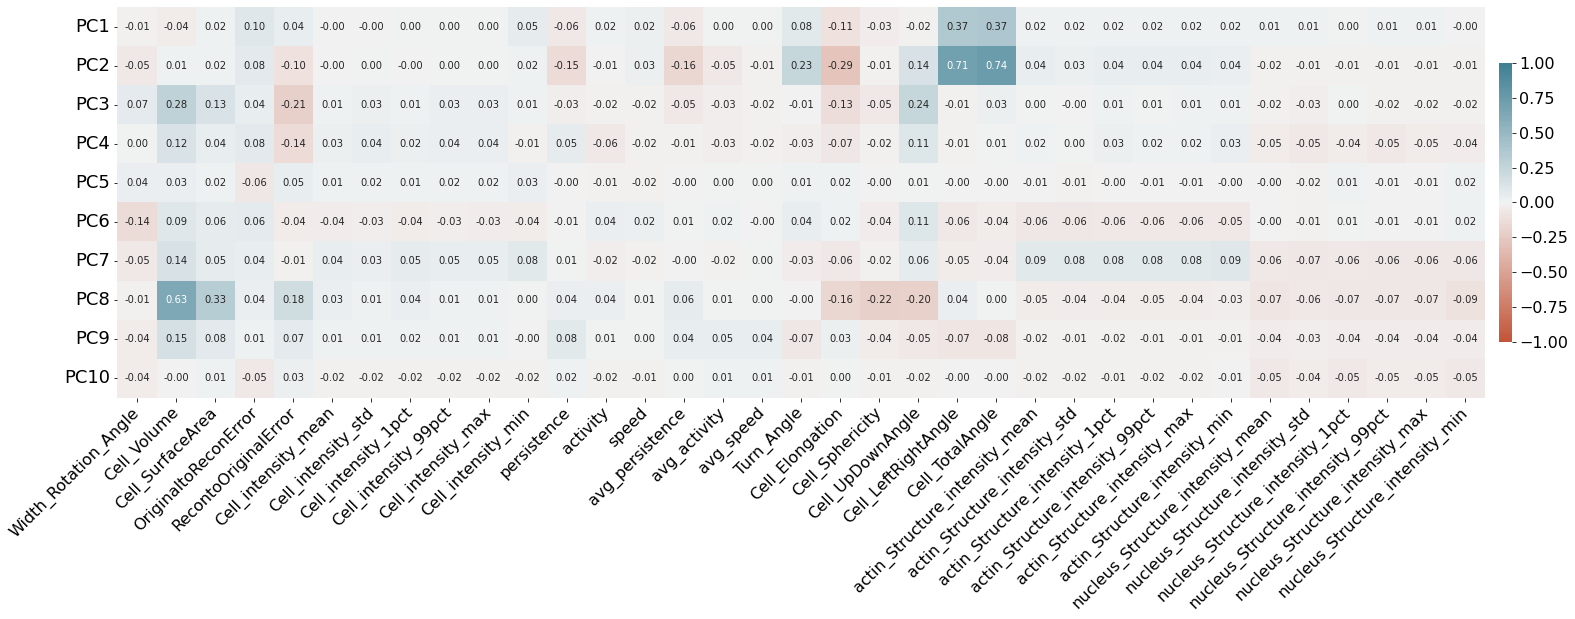

In [28]:
#correlations of shapes with PCs (PCs as rows)

coldrop = []
coldrop.extend([x for x in totalcorr.columns.to_list() if 'delta' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'PC' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist'])

PCsAndMetrics = totalcorr.loc[[x for x in totalcorr.index if 'PC' in x and 'delta' not in x]]
PCsAndMetrics = PCsAndMetrics.drop(columns = coldrop)
fig, ax = plt.subplots(figsize=(25,15))
ax = sns.heatmap(
    PCsAndMetrics, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.2f',
    cbar_kws={'fraction':0.01, 'pad':0.01}#, 'shrink': 0.5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 16
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    va = 'center',
    fontsize = 18
)
#scooch the x axis labels by a certain amount
dx = 6/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

plt.savefig(folder_fl + 'PC correlation with shape metrics heatmap.png', bbox_inches='tight')

In [19]:
len(PCsAndMetrics.columns)

48

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


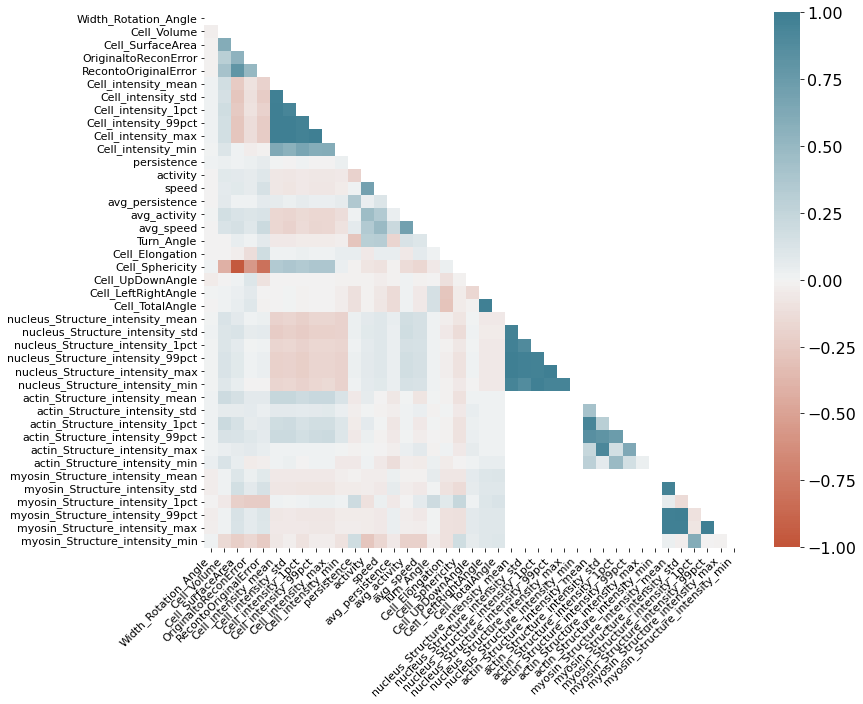

In [28]:
#get columns with nucleus and rows with cells from correlation matrix
coldrop = []
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist'])

PartFramecorr = TotalFrame.drop(columns = to_remove)
PartFramecorr = PartFramecorr.drop(columns = coldrop)
PartFramecorr = PartFramecorr.drop(columns = ([i for i in PartFramecorr.columns.to_list() if 'PC' in i]))
PartFramecorr = PartFramecorr.drop(columns = ([x for x in PartFramecorr.columns.to_list() if 'delta' in x]))
PartFramecorr = PartFramecorr.corr()

#comparison of CELL features
mask = np.zeros_like(PartFramecorr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    PartFramecorr,
    mask = mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 11
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
figsize = (5, 30)
plt.savefig(folder_fl + ' Shape Metric corr.png', bbox_inches='tight')

In [20]:
savedir

'D:/Aaron/Data/Chem_Galv_Combined/'